In [1]:
import sys
sys.path.append('/mnt/c/Users/frdnp/Desktop/Projects/dermoscopic-melanoma-classification/src/')

In [2]:
import torch
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.utils.data import DataLoader
from model import LiteSkinLesionClassifier
from preprocessing import get_transforms, ISICDataset
import yaml
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score


/mnt/c/Users/frdnp/Desktop/Projects/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def test_model(model, test_loader, device):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    return acc, auc, all_labels, all_preds

## 1. Removal sonuçları

In [ ]:
if __name__ == "__main__":
    with open("../config/config.yaml", "r") as f:
        config = yaml.safe_load(f)

    # Configurations
    image_size = (config['image_w'], config['image_h'])
    batch_size = config['batch_size']
    model_name = config['architecture']
    pretrained = config['pretrained']
    test_csv = config['test_csv']  # Add path to your test CSV
    model_save_path = config['model_save_path']

    # Load the test dataset
    df_test = pd.read_csv('/mnt/c/Users/frdnp/Desktop/Projects/dermoscopic-melanoma-classification/data/splits/test_dataset.csv')
    test_ds = ISICDataset(df_test, transform=get_transforms(image_size)[1])
    test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=config['num_workers'], shuffle=False)

    # Load the best model saved during training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LiteSkinLesionClassifier(model_name=model_name, pretrained=pretrained).to(device)
    model.load_state_dict(torch.load(os.path.join(model_save_path, "best_model_efficientnet_b0_1.pt")))

    # Evaluate the model on the test set
    test_acc, test_auc, all_labels, all_preds = test_model(model, test_loader, device)

    # Calculate precision, recall, sensitivity, specificity
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    # Sensitivity = Recall for the positive class
    sensitivity = recall
    # Specificity = TN / (TN + FP)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    specificity = tn / (tn + fp) if tn + fp != 0 else 0

    print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))
    print(confusion_matrix(all_labels, all_preds))
    # Print test results
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test ROC-AUC: {test_auc:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test Sensitivity: {sensitivity:.4f}")
    print(f"Test Specificity: {specificity:.4f}")

              precision    recall  f1-score   support

      Benign       0.83      0.87      0.85       947
   Malignant       0.86      0.82      0.84       946

    accuracy                           0.84      1893
   macro avg       0.84      0.84      0.84      1893
weighted avg       0.84      0.84      0.84      1893

[[826 121]
 [175 771]]
Test Accuracy: 0.8436
Test ROC-AUC: 0.9285
Test Precision: 0.8643
Test Recall: 0.8150
Test Sensitivity: 0.8150
Test Specificity: 0.8722


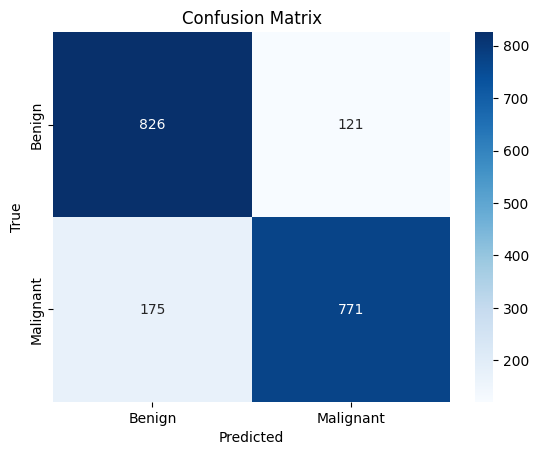

In [13]:
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues',
           xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### FP TN Örnek Tespiti

In [11]:
from PIL import Image
from torch.utils.data import Dataset

class ISICDataset(Dataset):
    def __init__(self, csv_file, transform=None, resize=False):
        self.data = csv_file
        self.transform = transform
        self.resize = resize

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img = Image.open(row['image_path']).convert("RGB")
        label = torch.tensor(row['label'], dtype=torch.long)
        image_id = row['image']
        
        if self.transform:
            img = self.transform(img)
        return img, label, image_id
    
def test_model(model, test_loader, device):
    model.eval()
    all_preds, all_probs, all_labels, all_image_ids = [], [], [], []
    
    with torch.no_grad():
        for imgs, labels, image_ids in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_labels.extend(labels.numpy())
            all_image_ids.extend(image_ids)
    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    return acc, auc, all_labels, all_preds, all_image_ids

In [ ]:
if __name__ == "__main__":
    with open("../config/config.yaml", "r") as f:
        config = yaml.safe_load(f)

    image_size = (config['image_w'], config['image_h'])
    batch_size = config['batch_size']
    model_name = config['architecture']
    pretrained = config['pretrained']
    test_csv = config['test_csv']
    model_save_path = config['model_save_path']

    df_test = pd.read_csv('/mnt/c/Users/frdnp/Desktop/Projects/dermoscopic-melanoma-classification/data/splits/test_dataset.csv')
    test_ds = ISICDataset(df_test, transform=get_transforms(image_size)[1])
    test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=config['num_workers'], shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LiteSkinLesionClassifier(model_name=model_name, pretrained=pretrained).to(device)
    model.load_state_dict(torch.load(os.path.join(model_save_path, "best_model_efficientnet_b0_1.pt")))

    test_acc, test_auc, all_labels, all_preds, all_image_ids = test_model(model, test_loader, device)

    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

    print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))
    print(confusion_matrix(all_labels, all_preds))
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test ROC-AUC: {test_auc:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall (Sensitivity): {recall:.4f}")
    print(f"Test Specificity: {specificity:.4f}")

    false_positives = [img_id for img_id, pred, true in zip(all_image_ids, all_preds, all_labels) if pred == 1 and true == 0]
    false_negatives = [img_id for img_id, pred, true in zip(all_image_ids, all_preds, all_labels) if pred == 0 and true == 1]

    print("\nFalse Positives (Benign olarak etiketli ama Malignant tahmini):")
    for img_id in false_positives:
        print(f" - {img_id}")

    print("\nFalse Negatives (Malignant olarak etiketli ama Benign tahmini):")
    for img_id in false_negatives:
        print(f" - {img_id}")

              precision    recall  f1-score   support

      Benign       0.83      0.87      0.85       947
   Malignant       0.86      0.82      0.84       946

    accuracy                           0.84      1893
   macro avg       0.84      0.84      0.84      1893
weighted avg       0.84      0.84      0.84      1893

[[826 121]
 [175 771]]
Test Accuracy: 0.8436
Test ROC-AUC: 0.9285
Test Precision: 0.8643
Test Recall (Sensitivity): 0.8150
Test Specificity: 0.8722

False Positives (Benign olarak etiketli ama Malignant tahmini):
 - ISIC_0011120
 - ISIC_0714807
 - ISIC_0071564
 - ISIC_0057605
 - ISIC_0032151
 - ISIC_7055743
 - ISIC_0027698
 - ISIC_0031867
 - ISIC_1750424
 - ISIC_0064011
 - ISIC_0065274
 - ISIC_3495555
 - ISIC_0034241
 - ISIC_0057451
 - ISIC_0030796
 - ISIC_3871414
 - ISIC_0029459
 - ISIC_0026279
 - ISIC_0010586
 - ISIC_0030064
 - ISIC_0072094
 - ISIC_0027949
 - ISIC_0011345
 - ISIC_0053732
 - ISIC_0522926
 - ISIC_0056869
 - ISIC_0062335
 - ISIC_0065601
 - ISIC_0032

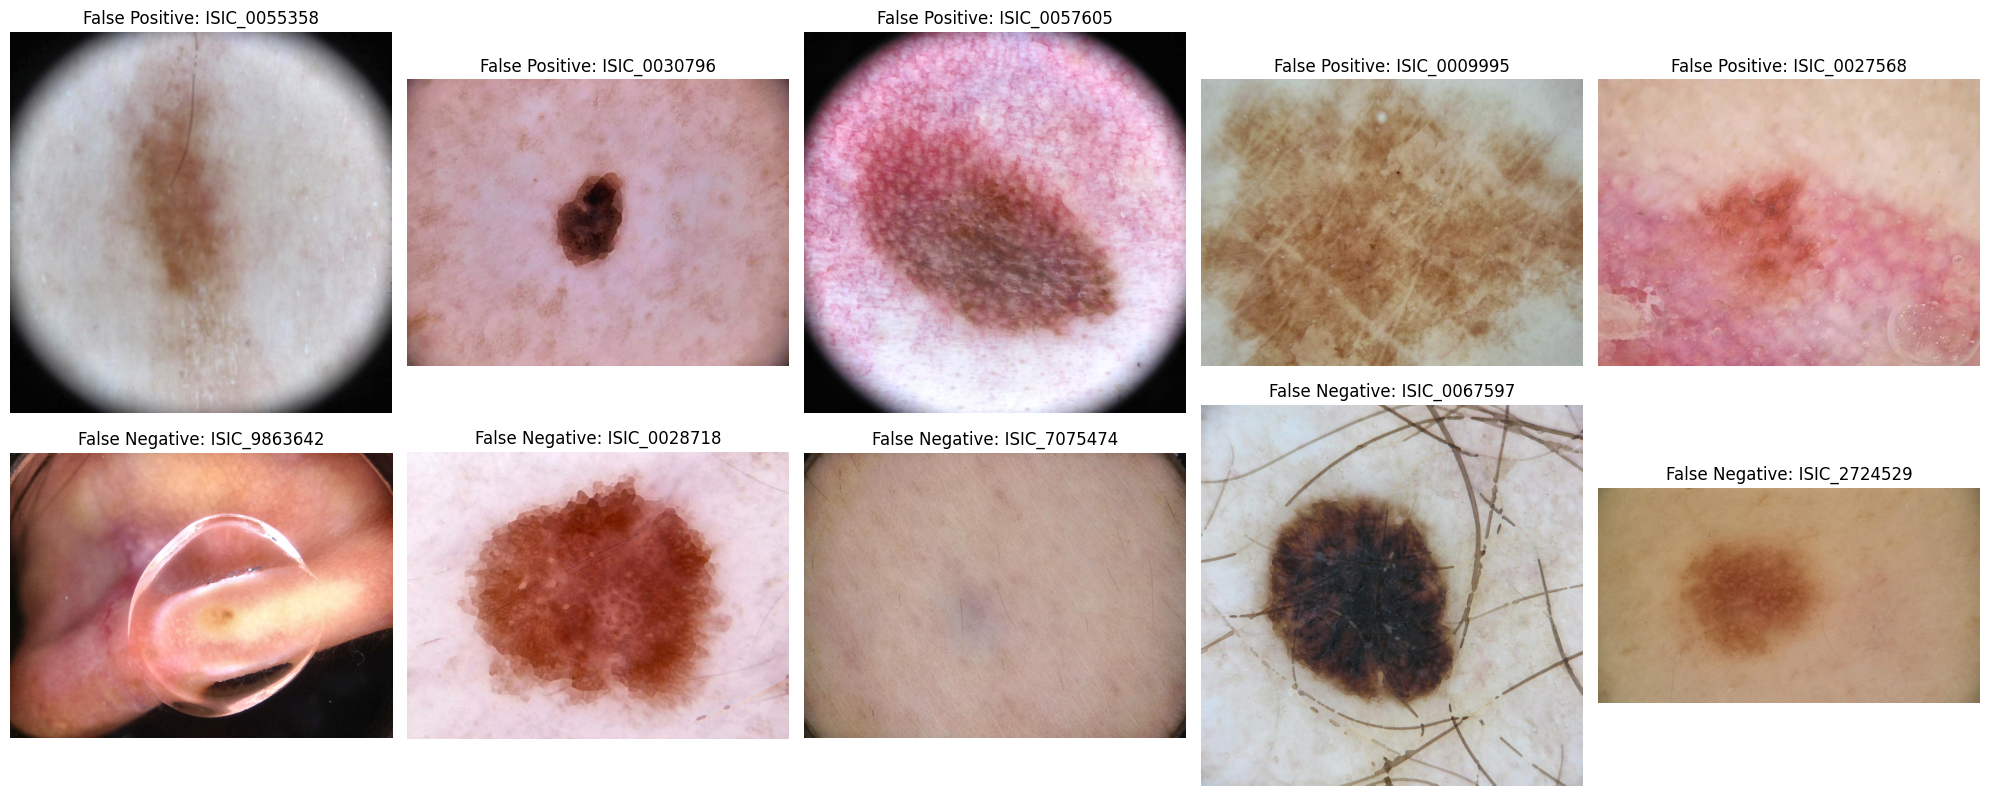

In [13]:
import random

random.seed(42)
fp_5 = random.sample(false_positives,5)
fn_5 = random.sample(false_negatives, 5)

fig,ax = plt.subplots(2, 5, figsize=(20, 8))
for i, img_id in enumerate(fp_5):
    img_path = df_test[df_test['image'] == img_id]['image_path'].values[0]
    img = Image.open(img_path).convert("RGB")
    ax[0, i].imshow(img)
    ax[0, i].set_title(f"False Positive: {img_id}")
    ax[0, i].axis('off')
for i, img_id in enumerate(fn_5):
    img_path = df_test[df_test['image'] == img_id]['image_path'].values[0]
    img = Image.open(img_path).convert("RGB")
    ax[1, i].imshow(img)
    ax[1, i].set_title(f"False Negative: {img_id}")
    ax[1, i].axis('off')
plt.tight_layout()
plt.show()

## 2. Raw train sonuçları

In [4]:
if __name__ == "__main__":
    with open("../config/config.yaml", "r") as f:
        config = yaml.safe_load(f)

    # Configurations
    image_size = (config['image_w'], config['image_h'])
    batch_size = config['batch_size']
    model_name = config['architecture']
    pretrained = config['pretrained']
    test_csv = config['test_csv']  # Add path to your test CSV
    model_save_path = config['model_save_path']

    # Load the test dataset
    df_test = pd.read_csv('/mnt/c/Users/frdnp/Desktop/Projects/dermoscopic-melanoma-classification/data/splits/test_dataset.csv')
    test_ds = ISICDataset(df_test, transform=get_transforms(image_size)[1])
    test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=config['num_workers'], shuffle=False)

    # Load the best model saved during training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LiteSkinLesionClassifier(model_name=model_name, pretrained=pretrained).to(device)
    model.load_state_dict(torch.load(os.path.join(model_save_path, "best_model_efficientnet_b0_2.pt")))

    # Evaluate the model on the test set
    test_acc, test_auc, all_labels, all_preds = test_model(model, test_loader, device)

    # Calculate precision, recall, sensitivity, specificity
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    # Sensitivity = Recall for the positive class
    sensitivity = recall
    # Specificity = TN / (TN + FP)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    specificity = tn / (tn + fp) if tn + fp != 0 else 0

    print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))
    print(confusion_matrix(all_labels, all_preds))
    # Print test results
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test ROC-AUC: {test_auc:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test Sensitivity: {sensitivity:.4f}")
    print(f"Test Specificity: {specificity:.4f}")


              precision    recall  f1-score   support

      Benign       0.83      0.84      0.84       947
   Malignant       0.84      0.82      0.83       946

    accuracy                           0.83      1893
   macro avg       0.83      0.83      0.83      1893
weighted avg       0.83      0.83      0.83      1893

[[799 148]
 [166 780]]
Test Accuracy: 0.8341
Test ROC-AUC: 0.9202
Test Precision: 0.8405
Test Recall: 0.8245
Test Sensitivity: 0.8245
Test Specificity: 0.8437


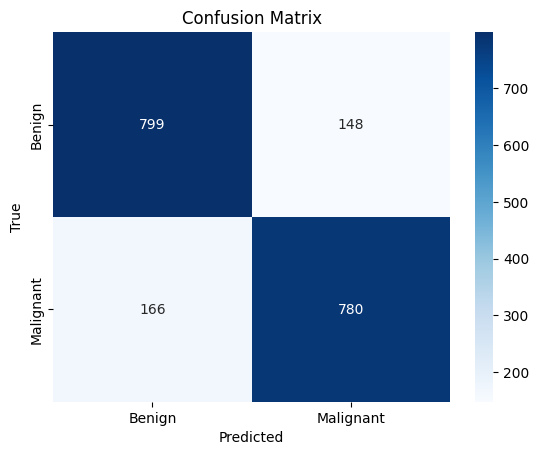

In [5]:
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues',
           xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()